In [233]:
#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import col, udf, lag, rank, lit
from pyspark.sql.window import Window
import talib

In [234]:
global DoEval #是否進行模型評估

# DoEval = False
# next_date_range = ["20180604", "20180605", "20180606", "20180607", "20180608"] #設定預測區間
next_date_range = ["20180528", "20180529", "20180530", "20180531", "20180601"] #設定預測區間
# next_date_range = ["20180521", "20180522", "20180523", "20180524", "20180525"] #設定預測區間
DoEval = True
# next_date_range = ["20180514", "20180515", "20180516", "20180517", "20180518"] #設定預測區間
ignore_dates = [""]#設定排除日(如端午節)
# next_date_range = ["20180507", "20180508", "20180509", "20180510", "20180511"] #設定預測區間
predict_start_date = next_date_range[0]

if sc.master[0:5]=="local":
    Path = "file:/c:/D Drive/work/bigData/pySpark/TBrain_Round2_DataSet_20180601"
    #Path = "file:/Users/yungchuanlee/Documents/learn/AI競賽/ETF預測/TBrain_Round2_DataSet_20180511"
    #Path = "file:/home/hduser/app/bigdata/competition/etf/TBrain_Round2_DataSet_20180518"
else:
    Path = "hdfs://master:9000/user/hduser"
# Path = "file:/home/hduser/app/bigdata/competition/etf/TBrain_Round2_DataSet_20180601"

In [235]:
#define alias of columns
col_alias_etf= {"代碼":"etf_id", "日期": "etf_date", "中文簡稱": "etf_name", "開盤價(元)":"etf_open", 
            "最高價(元)":"etf_high", "最低價(元)":"etf_low", "收盤價(元)":"etf_close", "成交張數(張)":"etf_count"}
col_alias_stock= {"代碼":"stock_id", "日期": "stock_date", "中文簡稱": "stock_name", "開盤價(元)":"stock_open", 
            "最高價(元)":"stock_high", "最低價(元)":"stock_low", "收盤價(元)":"stock_close", "成交張數(張)":"stock_count"}#udf
def to_double(str_val):
    return float(str_val.replace(",",""))
to_double=udf(to_double)

In [236]:
#def function to read data (因檔案格式都相同)
def read_data(file_name, col_alias):
    str_cols = ["代碼","日期", "中文簡稱"]
    raw_data = spark.read.option("encoding", "Big5").csv(Path + "/" + file_name, header=True, sep=",")
    print("Total " + file_name + " count: " + str(raw_data.count()))
    #rename cols and correct type 
    num_cols = [col_name for col_name in raw_data.columns if col_name not in str_cols]
    final_data=raw_data.select( [col(str_col_name).alias(col_alias[str_col_name]) for str_col_name in str_cols] + 
                                  [to_double(col(num_col_name)).cast("double").alias(col_alias[num_col_name]) for num_col_name in num_cols] )
    final_data.printSchema()
    final_data.show(5)
    return final_data

In [237]:
print("starting import tetfp.csv(台灣18檔ETF股價資料)...")
tetfp_dt=read_data("tetfp.csv", col_alias_etf)

starting import tetfp.csv(台灣18檔ETF股價資料)...
Total tetfp.csv count: 19485
root
 |-- etf_id: string (nullable = true)
 |-- etf_date: string (nullable = true)
 |-- etf_name: string (nullable = true)
 |-- etf_open: double (nullable = true)
 |-- etf_high: double (nullable = true)
 |-- etf_low: double (nullable = true)
 |-- etf_close: double (nullable = true)
 |-- etf_count: double (nullable = true)

+-------+--------+----------------+--------+--------+-------+---------+---------+
| etf_id|etf_date|        etf_name|etf_open|etf_high|etf_low|etf_close|etf_count|
+-------+--------+----------------+--------+--------+-------+---------+---------+
|0050   |20130102|元大台灣50          |    54.0|   54.65|   53.9|     54.4|  16487.0|
|0050   |20130103|元大台灣50          |    54.9|   55.05|  54.65|    54.85|  29020.0|
|0050   |20130104|元大台灣50          |   54.85|   54.85|   54.4|     54.5|   9837.0|
|0050   |20130107|元大台灣50          |   54.55|   54.55|   53.9|    54.25|   8910.0|
|0050   |20130108|元大台灣50     

In [238]:
#取出etf的distinct id
etf_ids = []
etf_id_dic = {}
etf_id_idx = 0
for row in tetfp_dt.select("etf_id").distinct().orderBy("etf_id").collect():
    etf_ids.append(row["etf_id"])
    etf_id_dic.update({row["etf_id"]: etf_id_idx})
    etf_id_idx += 1
etf_ids

['0050   ',
 '0051   ',
 '0052   ',
 '0053   ',
 '0054   ',
 '0055   ',
 '0056   ',
 '0057   ',
 '0058   ',
 '0059   ',
 '006201 ',
 '006203 ',
 '006204 ',
 '006208 ',
 '00690  ',
 '00692  ',
 '00701  ',
 '00713  ']

In [239]:
etf_dic = {}
for etfid in etf_ids:
    export_dt = tetfp_dt.filter("etf_id='" +etfid+ "' and etf_date < '" + predict_start_date + "'") \
        .orderBy("etf_id", "etf_date", ascending=True)
    export_pd = export_dt.toPandas()
    etf_dic.update({etfid.strip(): export_pd})

In [240]:
#functions of TA lib
print(talib.get_functions())

['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ADD', 'DIV', 'MAX', 'MAXINDEX', 'MIN', 'MININDEX', 'MINMAX', 'MINMAXINDEX', 'MULT', 'SUB', 'SUM', 'ACOS', 'ASIN', 'ATAN', 'CEIL', 'COS', 'COSH', 'EXP', 'FLOOR', 'LN', 'LOG10', 'SIN', 'SINH', 'SQRT', 'TAN', 'TANH', 'ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR',

In [241]:
etf_dic["0050"]["etf_close"].count()

1322

In [242]:
import math
def get_feature_pre(curr_list):
    #在feature前加上一個Nan後回傳, 第二個值則回傳原本的最後一個值作為下次的feature
    if type(curr_list) is pd.Series:
        rtn_list = curr_list.tolist()
    else:
        rtn_list = curr_list
    rtn_list = [None] + rtn_list
    return (rtn_list[:-1], [rtn_list[-1]])

def checkNan(num):
    if num == None:
        return True
    elif math.isnan(num):
        return True
    else:
        return False
    
def calculate_n_bias(close_price, ma):
#     (close price - MA)/MA
    if checkNan(close_price) or checkNan(ma):
        return None
    else:
        return (close_price - ma)/ma
    
def calculate_n_bias_list(close_ser, ma_list):
    #calculate n bias (20 days)
    bias_list = []
    for cprice, ma in zip(close_ser.tolist(), ma_list):
        bias_list.append(calculate_n_bias(cprice, ma))
    return bias_list

def calculate_bias_ma_list(ma3_list, ma6_list):
    #calculate bias_ma = (ma3-ma6)/ma6
    bias_list = []
    for ma3, ma6 in zip(ma3_list, ma6_list):
        bias_list.append(calculate_n_bias(ma3, ma6))
    return bias_list

def calculate_bias_3_6_list(bias3_list, bias6_list):
    #bias_3_6 = bias3 - bias6
    bias_list = []
    for bias3, bias6 in zip(bias3_list, bias6_list):
        if checkNan(bias3) or checkNan(bias6):
            bias_list.append(None)
        else:
            bias_list.append(bias3 - bias6)
    return bias_list

def calculate_dif(ema12_list, ema26_list):
    #差離值DIF = 12日EMA - 26日EMA 
    dif_list = []
    for ema12, ema26 in zip(ema12_list, ema26_list):
        if checkNan(ema12) or checkNan(ema26):
            dif_list.append(None)
        else:
            dif_list.append(ema12 - ema26)
    return dif_list

def my_log(x):
    if checkNan(x):
        return None
    elif x == 0:
        return 0.0
    else:
        return x

from sklearn.preprocessing import MinMaxScaler
import itertools
def create_feature(etf_pd, next_date):
    close_ser = etf_pd["etf_close"]
    #EMA
    ema5 = talib.EMA(close_ser,timeperiod=5)
    ema10 = talib.EMA(close_ser,timeperiod=10)
    ema20 = talib.EMA(close_ser,timeperiod=20)
    ema30 = talib.EMA(close_ser,timeperiod=30)
    #BIAS
    #nBIAS -3, 6, 20 => (close price - MA)/MA   ,Paper 建議用20日MA
    ma3 = talib.MA(np.array(close_ser), timeperiod=3)
    ma6 = talib.MA(np.array(close_ser), timeperiod=6)
    ma10 = talib.MA(np.array(close_ser), timeperiod=10)
    ma20 = talib.MA(np.array(close_ser), timeperiod=20)
    nbias3 = calculate_n_bias_list(close_ser, ma3)
    nbias6 = calculate_n_bias_list(close_ser, ma6)
    nbias20 = calculate_n_bias_list(close_ser, ma20)
    
    #BIAS_ma = (ma3-ma6)/ma6
    bias_ma = calculate_bias_ma_list(ma3, ma6)
    
    #bias_3_6 = bias3 - bias6
    bias_3_6 = calculate_bias_3_6_list(nbias3, nbias6)
    
    #KD --> only use STOCHRSI
    k, d = talib.STOCHRSI(close_ser, timeperiod=9, fastk_period=3, fastd_period=3, fastd_matype=1)
    
    #差離值DIF = 12日EMA - 26日EMA 
    ema12 = talib.EMA(close_ser,timeperiod=12)
    ema26 = talib.EMA(close_ser,timeperiod=26)
    dif = calculate_dif(ema12, ema26)
    
    #MACD
#     macd, macdsignal, macdhist = talib.MACD(close_ser, fastperiod=12, slowperiod=26, signalperiod=9)
#     macd, macdsignal, macdhist = talib.MACDFIX(close_ser, signalperiod=9)
    macd, macdsignal, macdhist = talib.MACDEXT(close_ser, fastperiod=12, fastmatype=0, 
                                               slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
    
    #RSI
    rsi = talib.RSI(close_ser, timeperiod=10)
    
    #CMO
    cmo = talib.CMO(close_ser, timeperiod=14)
    
    #ROCR - Rate of change ratio: (price/prevPrice)
    rocr = talib.ROCR(close_ser, timeperiod=10)
    
    #PPO - Percentage Price Oscillator
    ppo = talib.PPO(close_ser, fastperiod=12, slowperiod=26, matype=0)
    
    #APO - Absolute Price Oscillator
    apo = talib.APO(close_ser, fastperiod=12, slowperiod=26, matype=0)
    #MOM - Momentum
    mom = talib.MOM(close_ser, timeperiod=10)
    #TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
    trix = talib.TRIX(close_ser, timeperiod=30)
    
    #作出目前的feature table及預測用的feature table
    ema5 = [my_log(x) for x in ema5]
    ema10 = [my_log(x) for x in ema10 ]
    ma10 = [my_log(x) for x in ma10 ]
    ema20 = [my_log(x) for x in ema20 ]
    ema30 = [my_log(x) for x in ema30 ]
    ema5, next_ema5 = get_feature_pre(ema5)
    ema10, next_ema10 = get_feature_pre(ema10)
    ma10, next_ma10 = get_feature_pre(ma10)
    ema20, next_ema20 = get_feature_pre(ema20)
    ema30, next_ema30 = get_feature_pre(ema30)
    
    nbias3, next_nbias3 = get_feature_pre(nbias3)
    nbias6, next_nbias6 = get_feature_pre(nbias6)
    nbias20, next_nbias20 = get_feature_pre(nbias20)
    
    bias_ma, next_bias_ma = get_feature_pre(bias_ma)
    bias_3_6, next_bias_3_6 = get_feature_pre(bias_3_6)
    
    k = [my_log(x) for x in k ]
    d = [my_log(x) for x in d ]
    k, next_k = get_feature_pre(k)
    d, next_d = get_feature_pre(d)
    dif, next_dif = get_feature_pre(dif)
    
    macd, next_macd = get_feature_pre(macd)
    macdsignal, next_macdsignal = get_feature_pre(macdsignal)
    macdhist, next_macdhist = get_feature_pre(macdhist)
    
    rsi = [my_log(x) for x in rsi ]
    rsi, next_rsi = get_feature_pre(rsi)
    cmo, next_cmo = get_feature_pre(cmo)
    rocr, next_rocr = get_feature_pre(rocr)
    ppo, next_ppo = get_feature_pre(ppo)
    
    #"apo": apo, "mom": mom, "trix": trix
    apo, next_apo = get_feature_pre(apo)
    mom, next_mom = get_feature_pre(mom)
    trix, next_trix = get_feature_pre(trix)
    
    etfid = etf_pd["etf_id"].tolist()[0]
    etf_close = [my_log(x) for x in close_ser]
    rtn_pd = pd.DataFrame({"etf_id": etfid, "etf_date": etf_pd["etf_date"], "etf_close": etf_pd["etf_close"], 
                           "ema5": ema5, "ema10": ema10, "ema20": ema20, "ema30" : ema30, 
                          "nbias3": nbias3, "nbias6": nbias6, "nbias20": nbias20, "bias_ma": bias_ma,
                          "bias_3_6": bias_3_6, "k": k, "d": d, "dif": dif,
                          "macd": macd, "macdsignal": macdsignal, "macdhist": macdhist,
                          "rsi": rsi, "cmo": cmo, "rocr": rocr, "ppo": ppo,
                          "apo": apo, "mom": mom}).dropna(how='any')
#     scaler = MinMaxScaler()
#     rtn_pd['cmo'] = list(itertools.chain.from_iterable(scaler.fit_transform(rtn_pd[['cmo']])))
    
#     next_cmo = [scaler.transform(x) for x in next_cmo]
    next_pd = pd.DataFrame({"etf_id": etfid, "etf_date": next_date, "etf_close": -1, 
                           "ema5": next_ema5, "ema10": next_ema10, "ema20": next_ema20, "ema30" : next_ema30, 
                          "nbias3": next_nbias3, "nbias6": next_nbias6, "nbias20": next_nbias20, "bias_ma": next_bias_ma,
                          "bias_3_6": next_bias_3_6, "k": next_k, "d": next_d, "dif": next_dif,
                          "macd": next_macd, "macdsignal": next_macdsignal, "macdhist": next_macdhist,
                          "rsi": next_rsi, "cmo": next_cmo, "rocr": next_rocr, "ppo": next_ppo,
                           "apo": next_apo, "mom": next_mom, "trix": next_trix})
 
    return (rtn_pd, next_pd)

In [243]:
#EMA
etf_pd_dic = {}
next_pd_dic = {}
for etfid in etf_ids:
    etf_pd, next_pd = create_feature(etf_dic[etfid.strip()], predict_start_date)
    etf_pd_dic.update({etfid.strip() : etf_pd})
    next_pd_dic.update({etfid.strip() : next_pd})

In [244]:
etf_pd_dic["0050"].describe()

,apo,bias_3_6,bias_ma,cmo,d,dif,ema10,ema20,ema30,ema5,...,macd,macdhist,macdsignal,mom,nbias20,nbias3,nbias6,ppo,rocr,rsi
count,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,...,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000,1288.000000
mean,0.140160,-0.000461,0.000445,6.912824,53.055495,0.144500,67.637529,67.535874,67.429520,67.687847,...,0.140160,-0.000670,0.140830,0.202407,0.002924,0.000299,0.000760,0.210753,1.003331,53.556605
std,0.842154,0.006187,0.006189,23.490450,29.974075,0.557058,8.800700,8.759026,8.722484,8.825937,...,0.842154,0.425791,0.792472,1.756104,0.020179,0.006503,0.010563,1.264435,0.026040,14.163917
min,-2.758974,-0.021165,-0.025978,-76.323875,0.265534,-2.005714,54.107178,54.340747,54.461521,53.746667,...,-2.758974,-1.874858,-2.369160,-8.650000,-0.098039,-0.037074,-0.056733,-3.585166,0.890782,7.358437
25%,-0.393910,-0.004338,-0.003023,-8.944650,25.280712,-0.169287,60.680411,60.761687,60.557446,60.527471,...,-0.393910,-0.265073,-0.369115,-0.950000,-0.010041,-0.003232,-0.004948,-0.595941,0.985948,43.711959
50%,0.237821,-0.000630,0.000626,7.961380,53.659418,0.204497,66.484886,66.498860,66.321831,66.554562,...,0.237821,-0.047454,0.242949,0.300000,0.004628,0.000547,0.001524,0.345470,1.004217,54.417350
75%,0.711058,0.003005,0.004315,22.945045,79.788740,0.523272,72.544892,72.360687,72.220463,72.650078,...,0.711058,0.261797,0.678454,1.400000,0.016598,0.004192,0.007441,1.071703,1.021420,63.764739
max,2.010256,0.026075,0.020991,76.484275,99.984945,1.451904,86.647274,85.456141,84.814623,87.334741,...,2.010256,1.520726,1.883405,4.650000,0.050234,0.029971,0.033427,3.034640,1.071649,91.060883


In [245]:
#作出訓練集
etfids_1 = ["0050", "0051", "0052", "0053", "0057", "0058", "006201", "006203", "006204", "006208"]
etfids_2 = ["00690","00692", "00701", "00713"]
etfids_3 = [etfid.strip() for etfid in etf_ids if etfid.strip() not in etfids_1 and etfid.strip() not in etfids_2 ]

train_dt1 = pd.concat([etf_pd_dic[etfid] for etfid in etfids_1 + etfids_3 + etfids_2])
print('train_dt1 count:', train_dt1.shape)
train_dt2 = pd.concat([etf_pd_dic[etfid] for etfid in etfids_2])
print('train_dt2 count:', train_dt2.shape)


train_dt1 count: (18783, 24)
train_dt2 count: (751, 24)


In [246]:
non_feature_list = ['etf_id', 'etf_date', 'etf_close']
ema_feature_list = ['ema5','ema10', 'ema20', 'ema30']

In [247]:
import xgboost as xgb
# feature_cols = ema_feature_list+[col for col in list(train_dt1.columns.values) if col not in non_feature_list+ema_feature_list]
# feature_cols = [col for col in list(train_dt1.columns.values) if col not in non_feature_list]
# feature_cols = ['bias_3_6', 'bias_ma', 'cmo', 'd', 'dif', 'ema10', 'ema20', 'ema30', 'ema5', 'k', 'macd', 'macdhist', 'macdsignal', 'nbias20', 'nbias3', 'nbias6', 'ppo', 'rocr', 'rsi', 'ema15']
feature_cols = ['ema10', 'ema30']
#$$$ parameter
rf_model1 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, 
        colsample_bytree=1, max_depth=68, n_jobs=4, min_child_weight=0 )
train_x1 = train_dt1[feature_cols].values
train_y1 = train_dt1["etf_close"].values
rf_model1.fit(train_x1, train_y1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=68, min_child_weight=0, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [248]:
print(feature_cols)

['ema10', 'ema30']


In [249]:
train_dt1.loc[(train_dt1["etf_id"] == "0050   ") & (train_dt1["etf_date"] < predict_start_date) ].iloc[-1]["etf_close"]
next_pd_dic["0050"]["etf_close"] = -2
pd_0050=etf_dic["0050"]
pd_0050#.loc[~pd_0050["etf_date"].isin(next_date_range)]

,etf_id,etf_date,etf_name,etf_open,etf_high,etf_low,etf_close,etf_count
0,0050,20130102,元大台灣50,54.00,54.65,53.90,54.40,16487.0
1,0050,20130103,元大台灣50,54.90,55.05,54.65,54.85,29020.0
2,0050,20130104,元大台灣50,54.85,54.85,54.40,54.50,9837.0
3,0050,20130107,元大台灣50,54.55,54.55,53.90,54.25,8910.0
4,0050,20130108,元大台灣50,54.00,54.20,53.65,53.90,12507.0
5,0050,20130109,元大台灣50,53.75,54.30,53.75,54.10,7529.0
6,0050,20130110,元大台灣50,54.30,54.65,54.15,54.50,13953.0
7,0050,20130111,元大台灣50,54.70,54.80,54.35,54.45,11837.0
8,0050,20130114,元大台灣50,54.00,54.50,53.80,54.50,7282.0
9,0050,20130115,元大台灣50,54.20,54.45,53.90,54.00,6609.0


In [250]:
from pyspark.sql.types import ArrayType, DoubleType, IntegerType
#計算上或下的值(udf)
def judge_up_down_pred_native(curr_price, prev_close_price):
    if checkNan(prev_close_price):
        return 0.0
    else:
        prev_price = prev_close_price
        if curr_price == prev_price:
            return 0.0
        elif curr_price > prev_price:
            return 1.0
        else:
            return 2.0
judge_up_down_pred=udf(judge_up_down_pred_native, DoubleType())

In [251]:
next_date_range[-1]

'20180601'

In [252]:
#recover to re-run
for eid in etf_ids:
    etf_dt = etf_dic[eid.strip()]
    etf_dt = etf_dt.loc[~etf_dt["etf_date"].isin(next_date_range)]
    etf_dic.update({eid.strip(): etf_dt})
predict_res_final = []
for date in next_date_range:
    for eid in etf_ids:
        #do predict
        pred_data = next_pd_dic[eid.strip()][feature_cols].values
        pred_res = rf_model1.predict(data=pred_data)
#         print(pred_res)
        prediction = pred_res[0]
#         prediction = math.exp(pred_res[0])
        
        etf_dt = etf_dic[eid.strip()]
        prev_dt = etf_dt.loc[(etf_dt["etf_date"] < date) ].iloc[-1]
#         print('id of prev_dt: ', eid, ', date: ' ,prev_dt["etf_date"])
        prev_close = prev_dt["etf_close"]
        #取出所有預測結果作合併，以進行後續成績計算
        predict_res_final.append({
            'etf_id': eid, 'etf_date': date,
            'prediction': prediction, 'pred_ud': judge_up_down_pred_native(pred_res, prev_close)
        })
        
        if date != next_date_range[-1]:
            #作出新的next_pd
            new_dic = {'etf_id': [eid], 'etf_date': [date], 'etf_name': [''], 
                       'etf_open': [0.0],  'etf_high': [0.0], 'etf_low': [0.0], 'etf_close': [prediction], 'etf_count': [0.0]}
            new_pd = pd.DataFrame(data=new_dic)[['etf_id','etf_date','etf_name', 'etf_open', 'etf_high', 
                                                      'etf_low', 'etf_close', 'etf_count']]
            #print(new_pd)
            etf_dt=etf_dt.append(new_pd, ignore_index=True)
            next_date = next_date_range[next_date_range.index(date)+1]
            etf_pd2, next_pd2 = create_feature(etf_dt, next_date)
            etf_dic.update({eid.strip(): etf_dt})
            next_pd_dic.update({eid.strip(): next_pd2})

pd.DataFrame(predict_res_final)

,etf_date,etf_id,pred_ud,prediction
0,20180528,0050,1.0,81.947105
1,20180528,0051,1.0,33.799225
2,20180528,0052,2.0,52.230694
3,20180528,0053,1.0,35.884850
4,20180528,0054,2.0,24.112326
5,20180528,0055,2.0,17.566324
6,20180528,0056,2.0,26.311436
7,20180528,0057,2.0,50.239162
8,20180528,0058,1.0,47.188271
9,20180528,0059,2.0,42.780411


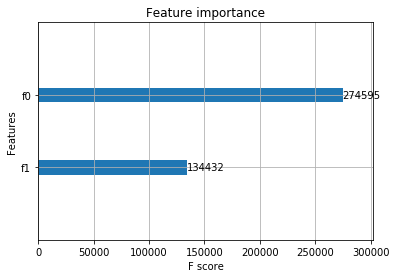

In [253]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(rf_model1)
pyplot.show()

In [254]:
pd_0050=etf_dic["0050"]
prev_date = pd_0050.loc[~pd_0050["etf_date"].isin(next_date_range)]["etf_date"].max()
prev_date

'20180525'

In [255]:
#declare previous row windows
wsSpec_etf = Window.partitionBy('etf_id').orderBy('etf_date') #time window for normal case
#eval dt for evluate score
tetf_dt_eval = tetfp_dt.filter(tetfp_dt.etf_date.isin([prev_date] + next_date_range)) \
    .withColumn("prev_close", lag(col('etf_close')).over(wsSpec_etf)) \
    .withColumn("act_ud", judge_up_down_pred(col("etf_close"), col("prev_close")))
tetf_dt_eval = tetf_dt_eval.filter(tetf_dt_eval.etf_date.isin(next_date_range))
tetf_dt_eval.cache()
tetf_dt_eval.show()

+-------+--------+----------------+--------+--------+-------+---------+---------+----------+------+
| etf_id|etf_date|        etf_name|etf_open|etf_high|etf_low|etf_close|etf_count|prev_close|act_ud|
+-------+--------+----------------+--------+--------+-------+---------+---------+----------+------+
|00701  |20180528|   國泰臺灣低波動30    |   21.29|   21.29|  21.23|    21.24|     59.0|     21.21|   1.0|
|00701  |20180529|   國泰臺灣低波動30    |    21.2|    21.2|  21.08|    21.08|     94.0|     21.24|   2.0|
|00701  |20180530|   國泰臺灣低波動30    |    21.0|    21.0|  20.78|    20.78|     42.0|     21.08|   2.0|
|00701  |20180531|   國泰臺灣低波動30    |    20.9|    20.9|  20.85|    20.87|      6.0|     20.78|   1.0|
|00701  |20180601|   國泰臺灣低波動30    |   20.89|   21.03|  20.89|    21.03|    101.0|     20.87|   1.0|
|0051   |20180528|元大中型100         |   33.85|   33.91|  33.85|    33.87|      9.0|     33.66|   1.0|
|0051   |20180529|元大中型100         |   33.98|   33.98|  33.97|    33.97|     10.0|     33.87|   1.0|


In [256]:
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
if DoEval:
    predict_res_final_dt = spark.createDataFrame(pd.DataFrame(predict_res_final))
    eval_dt = predict_res_final_dt.join(tetf_dt_eval, ["etf_id", "etf_date"], "inner")
#     eval_dt = eval_dt.filter(trim(eval_dt.etf_id).isin(etfids_1+etfids_3))
    eval_dt.cache()
    #eval_dt.orderBy("etf_id", "etf_date", ascending=True).show(10)
    evaluator = RegressionEvaluator(
        labelCol="etf_close", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(eval_dt)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
    evaluator = MulticlassClassificationEvaluator(
        labelCol="act_ud", predictionCol="pred_ud", metricName="accuracy")
    accuracy = evaluator.evaluate(eval_dt)
    print("accuracy = %g " % accuracy)
    
    #define method to evaluate by ETF way
    final_res = eval_dt.select("etf_id", "etf_date", "prediction", "pred_ud", "etf_close", "act_ud") \
        .orderBy("etf_date", "etf_id").collect()
    weights = [0.1, 0.15, 0.2, 0.25, 0.3]
    judge_score = 0.0
    for row in final_res:
        #(up equal*0.5+((act_p - abs(pred_p - act_p))/act_p)*0.5)*weight
        act_price = row["etf_close"]
        pred_price = row["prediction"]
        eidx = next_date_range.index(row["etf_date"])
        judge_score = judge_score + \
            ((0.5 if row["pred_ud"] == row["act_ud"] else 0) + \
             ((act_price-abs(pred_price-act_price))/act_price)*0.5)*weights[eidx]
    print("final score: ", judge_score)

#$$$
# 5/28 (RMSE) on test data = 0.444304    accuracy = 0.555556   final score:  14.037520270028685

Root Mean Squared Error (RMSE) on test data = 0.409531
accuracy = 0.433333 
final score:  12.870227142355374


In [257]:
final_res = spark.createDataFrame(pd.DataFrame(predict_res_final)).orderBy("etf_id", "etf_date").collect()
#export to pandas
etf_ids = []
mon_ud = []
mon_price = [] 
tue_ud = []
tue_price = []
wed_ud = []
wed_price = []
thu_ud = []
thu_price = []
fri_ud = []
fri_price = []

def encode_ud(oper_ud):
    if oper_ud == 0.0:
        return 0
    elif oper_ud == 1.0:
        return 1
    else:
        return -1

for row in final_res:
    etf_id = row["etf_id"]
    if etf_id not in etf_ids:
        etf_ids.append(etf_id)
    etf_date = row["etf_date"]
    eidx = next_date_range.index(row["etf_date"])
    if eidx == 0:
        mon_ud.append(encode_ud(row["pred_ud"]))
        mon_price.append(row["prediction"])
    elif eidx == 1:
        tue_ud.append(encode_ud(row["pred_ud"]))
        tue_price.append(row["prediction"])
    elif eidx == 2:
        wed_ud.append(encode_ud(row["pred_ud"]))
        wed_price.append(row["prediction"])
    elif eidx == 3:
        thu_ud.append(encode_ud(row["pred_ud"]))
        thu_price.append(row["prediction"])
    elif eidx == 4:
        fri_ud.append(encode_ud(row["pred_ud"]))
        fri_price.append(row["prediction"])
        
if len(mon_ud) == 0:
    mon_ud = list(0 for i in range(0,len(etf_ids)))
    mon_price = list(0.0 for i in range(0,len(etf_ids)))
if len(tue_ud) == 0:
    tue_ud = list(0 for i in range(0,len(etf_ids)))
    tue_price = list(0.0 for i in range(0,len(etf_ids)))
if len(wed_ud) == 0:
    wed_ud = list(0 for i in range(0,len(etf_ids)))
    wed_price = list(0.0 for i in range(0,len(etf_ids)))
if len(thu_ud) == 0:
    thu_ud = list(0 for i in range(0,len(etf_ids)))
    thu_price = list(0.0 for i in range(0,len(etf_ids)))
if len(fri_ud) == 0:
    fri_ud = list(0 for i in range(0,len(etf_ids)))
    fri_price = list(0.0 for i in range(0,len(etf_ids)))
    
dic = {"ETFid": etf_ids, 
       "Mon_ud": mon_ud, "Mon_cprice": mon_price,
       "Tue_ud": tue_ud, "Tue_cprice": tue_price,
       "Wed_ud": wed_ud, "Wed_cprice": wed_price,
       "Thu_ud": thu_ud, "Thu_cprice": thu_price,
       "Fri_ud": fri_ud, "Fri_cprice": fri_price
      }
final_df = pd.DataFrame(data=dic)[['ETFid','Mon_ud','Mon_cprice','Tue_ud','Tue_cprice',
                                  'Wed_ud','Wed_cprice','Thu_ud','Thu_cprice',
                                  'Fri_ud','Fri_cprice']]
final_df

,ETFid,Mon_ud,Mon_cprice,Tue_ud,Tue_cprice,Wed_ud,Wed_cprice,Thu_ud,Thu_cprice,Fri_ud,Fri_cprice
0,0050,1,81.947105,1,82.306915,-1,81.416321,1,81.447548,-1,81.198410
1,0051,1,33.799225,-1,33.466904,1,33.601284,1,33.862572,-1,33.807125
2,0052,-1,52.230694,1,52.264317,1,52.272991,-1,52.264618,-1,52.259823
3,0053,1,35.884850,-1,35.402691,1,35.561497,-1,35.517551,1,35.533596
4,0054,-1,24.112326,1,24.206657,-1,24.123802,-1,23.924683,1,24.131756
5,0055,-1,17.566324,0,17.566324,0,17.566324,0,17.566324,0,17.566324
6,0056,-1,26.311436,1,26.352560,-1,26.278620,1,26.343702,-1,26.332891
7,0057,-1,50.239162,1,50.336964,1,50.343578,1,50.453911,-1,50.229301
8,0058,1,47.188271,1,47.478085,1,47.785748,-1,47.587605,1,47.800980
9,0059,-1,42.780411,1,43.053516,-1,42.492592,1,42.679268,1,42.863972


In [258]:
final_df.to_csv(Path.replace("file:/","") + "/etf_price_pred_talib_mac.csv",index=False)

In [259]:
if DoEval:
    res_dt = eval_dt.select("etf_id", "etf_date", "pred_ud", "act_ud", "prediction", "etf_close") \
        .filter("pred_ud != act_ud") \
        .orderBy("etf_id", "etf_date")
    res_dt.groupBy("etf_id").count().orderBy("count").show()

+-------+-----+
| etf_id|count|
+-------+-----+
|00701  |    1|
|006204 |    2|
|0050   |    2|
|0053   |    2|
|0054   |    2|
|0059   |    2|
|00690  |    2|
|0051   |    3|
|0056   |    3|
|00713  |    3|
|006208 |    3|
|00692  |    3|
|0058   |    3|
|006201 |    3|
|0057   |    4|
|006203 |    4|
|0052   |    4|
|0055   |    5|
+-------+-----+



In [260]:
if DoEval:
    eval_pd=eval_dt.toPandas()

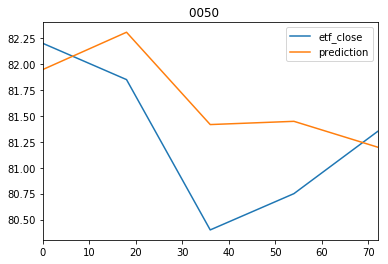

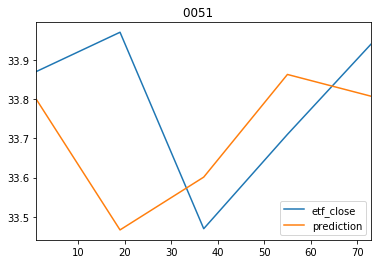

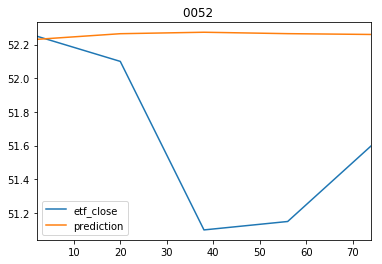

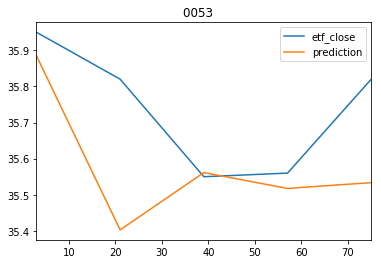

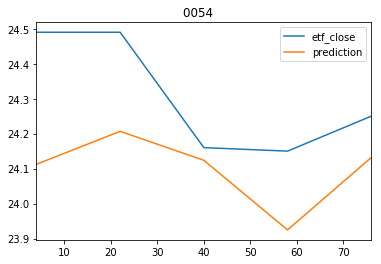

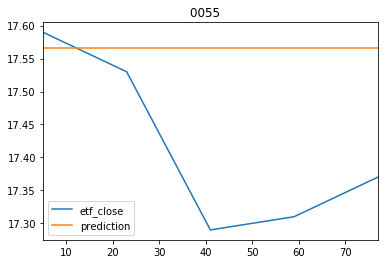

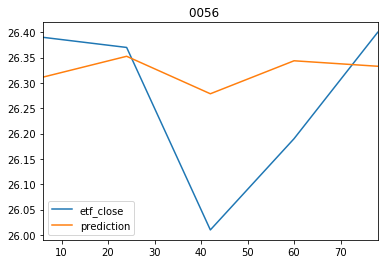

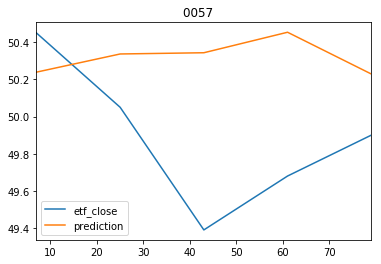

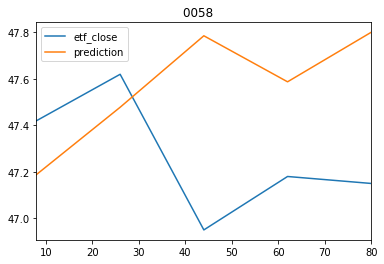

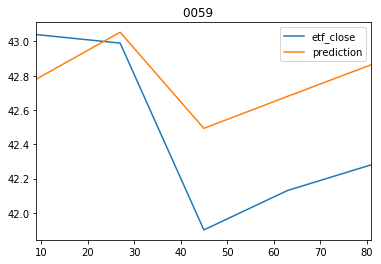

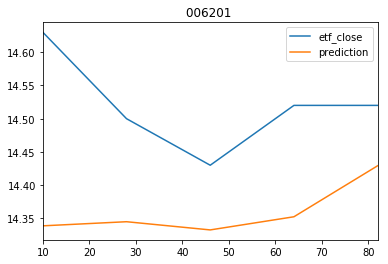

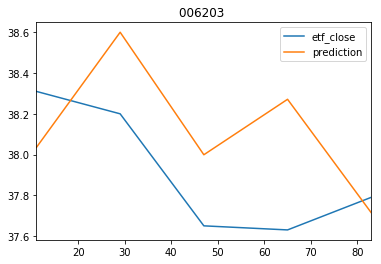

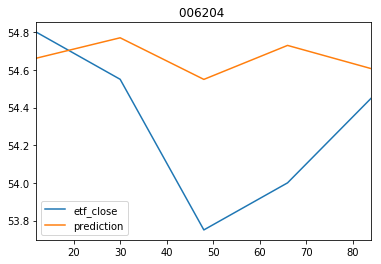

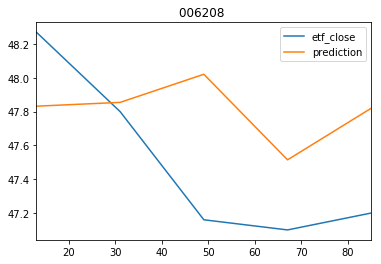

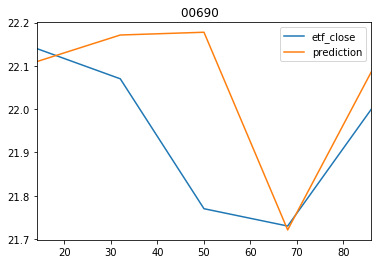

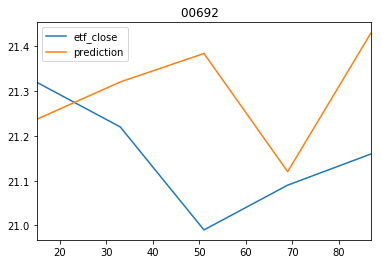

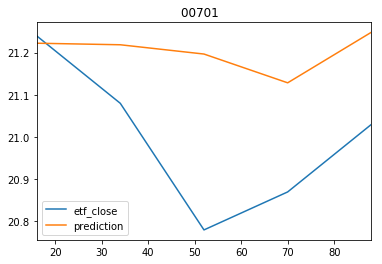

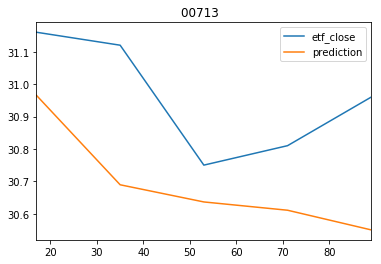

In [261]:
if DoEval:
    for eid in etf_ids:
        eval_pd[eval_pd['etf_id'].isin([eid])][['etf_close','prediction']].plot(title=eid)
    pyplot.show()